# Confidence quantification using randomized bootstrap analysis

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
# from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

# file containing functions:
import loadquakes
from loadquakes import calculate_bayes
from tqdm import tqdm
importlib.reload(loadquakes)
plt.style.use('fivethirtyeight')

In [2]:
# GRACE data
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")
catalog = pd.read_csv('catalog.csv')
etas_declustered = pd.read_csv('etas_declustered.csv')
NND_declustered = pd.read_csv('NND_declustered.csv') # eta0 = 10
NND_declustered_v2 = pd.read_csv('NND_declustered_v2.csv') # eta0 = 10**3

In [3]:
sliq_full=catalog.sort_values('cp',ascending=False)
sliq_full=sliq_full.reset_index()
sliq_full=sliq_full.drop(['index'], axis=1)

sliq_full['dmass']=sliq_full['dmass'].astype(float)

In [4]:
# def get_mass(eq):
#     mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
#     mass_change = mass_change["lwe_thickness"]
#     return mass_change.data
  
# etas_declustered['dmass'] = etas_declustered.apply(lambda row: get_mass(row), axis=1)
# catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

In [6]:
all_grace_data = np.array(ds.lwe_thickness).flatten()
rng = np.random.default_rng()
cp_real_distribution = np.array([])
nsliq = 500
N = 100
for i in tqdm(range(N)):
    random_sample = rng.choice(all_grace_data, size=nsliq)
    this_cp,bins = calculate_bayes( random_sample , all_grace_data, 'fd')
    cp_real_distribution = np.hstack((cp_real_distribution,this_cp))

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


In [7]:
p10 = 1.5
np.round(sum(cp_real_distribution<p10)/len(cp_real_distribution),2)

0.88

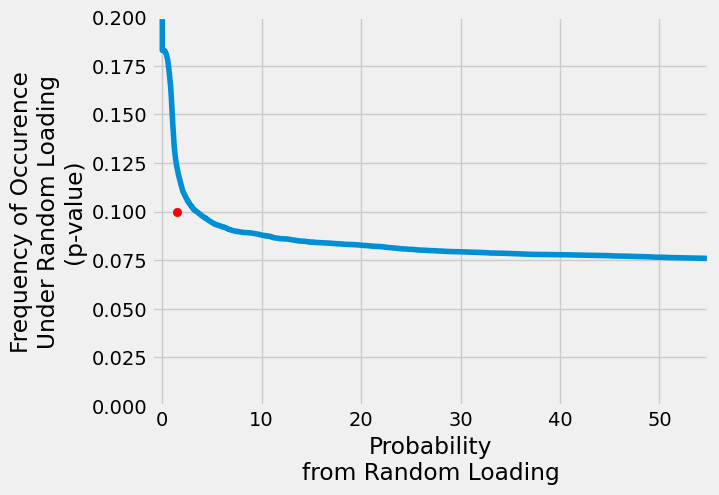

In [8]:

sorted_data = np.sort(cp_real_distribution)
plt.plot(sorted_data, 1-np.arange(sorted_data.size)/sorted_data.size)
plt.scatter(p10,0.1,c='r',zorder=29)
plt.ylabel('Frequency of Occurence\nUnder Random Loading\n(p-value)')
plt.xlabel('Probability\nfrom Random Loading')
plt.xlim(-1,55)
plt.ylim([0,0.2])
plt.show()
